In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import json
import os
import matplotlib.pylab as plt
import cv2
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1.Load DataSet

In [ ]:
class Data_base(Dataset):
    def __init__(self, images_dir, masks_dir, label2cmap_file, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.label2cmap = self.load_label2cmap(label2cmap_file)
        self.image_names = os.listdir(images_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_names[idx])
        mask_name = os.path.join(self.masks_dir, self.image_names[idx].replace(".jpg", ".png"))

        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("RGB")

        if self.transform:
            image = self.transform(image)
            mask = self.transform_mask(mask)

        return image, mask
    def transform_mask(self, mask):
        mask_array = torch.zeros((224, 224), dtype=torch.int64)
        mask_resized = mask.resize((224, 224), Image.NEAREST)
        for i, rgb_values in enumerate(self.label2cmap.values()):
            class_label = i
            for y in range(mask_resized.size[1]):
                for x in range(mask_resized.size[0]):
                    pixel_rgb = mask_resized.getpixel((x, y))[:3]
                    if pixel_rgb == tuple(rgb_values):
                        mask_array[y, x] = class_label
        return mask_array


    def load_label2cmap(self, label2cmap_file):
        with open(label2cmap_file, 'r') as f:
            label2cmap = json.load(f)
        return label2cmap


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

IMAGES_PATH = r"/content/drive/MyDrive/dataset/images"
MASKS_PATH = r"/content/drive/MyDrive/dataset/masks"
LABEL2CMAP_FILE = r"/content/drive/MyDrive/dataset/label2cmap.json"

dataset = Data_base(images_dir=IMAGES_PATH, masks_dir=MASKS_PATH, label2cmap_file=LABEL2CMAP_FILE, transform=transform)

split_path = '/content/drive/MyDrive/dataset/train_test_split.json'
with open(split_path, 'r') as f:
    split_data = json.load(f)
train_indices = split_data['train']
test_indices = split_data['test']


train_indices = [dataset.image_names.index(fname) for fname in train_indices if fname in dataset.image_names]
test_indices = [dataset.image_names.index(fname) for fname in test_indices if fname in dataset.image_names]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

batch_size = 4
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
sample_img, sample_mask = train_dataset[5]
print("Image size:", sample_img.size())
print("Mask size:", sample_mask.size())

Image size: torch.Size([3, 224, 224])
Mask size: torch.Size([224, 224])


# 2.ResNet Without Skip Connections

In [ ]:
class Resnet18_without_skip_connections(nn.Module):
    def __init__(self, num_classes):
        super(Resnet18_without_skip_connections, self).__init__()
        self.resnet18 = models.resnet18(weights=models.resnet.ResNet18_Weights.IMAGENET1K_V1, progress=True)
        self.features = nn.Sequential(*list(self.resnet18.children())[:-2])
        self.conv1 = nn.Conv2d(512, 150, kernel_size = 1)
        self.upsample1 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.conv2 = nn.Conv2d(150, 30, kernel_size = 1)
        self.upsample2 = nn.Upsample(size=(224,224), mode='bilinear', align_corners=True)
        self.conv3 = nn.Conv2d(30, 9, kernel_size = 1)

    def forward(self, model):
        model = model.to(torch.float32)
        model = self.features(model)
        model = self.conv1(model)
        model = self.upsample1(model)
        model = self.conv2(model)
        model = self.upsample2(model)
        model = self.conv3(model)
        return model

In [ ]:
#Train Our Model on without skip Connection
alpha = 0.001
num_classes = 9
num_epochs = 10

without_skip_model = Resnet18_without_skip_connections(num_classes)
for x in without_skip_model.resnet18.parameters():
    x.requires_grad = False
Loss_calculation = nn.CrossEntropyLoss()
optmized_version = torch.optim.Adam(without_skip_model.parameters(), lr=alpha)

for epoch in range(num_epochs):
    without_skip_model = without_skip_model.to(device)
    without_skip_model.train()
    running_loss = 0.0
    for inputs, targets in data_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outs = without_skip_model(inputs)
      targets = targets.to(torch.int64)
      loss = Loss_calculation(outs, targets)
      optmized_version.zero_grad()
      loss.backward()
      optmized_version.step()
      running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


Epoch [1/10], Loss: 0.6175
Epoch [2/10], Loss: 0.3546
Epoch [3/10], Loss: 0.3014
Epoch [4/10], Loss: 0.2932
Epoch [5/10], Loss: 0.2796
Epoch [6/10], Loss: 0.2808
Epoch [7/10], Loss: 0.2407
Epoch [8/10], Loss: 0.2485
Epoch [9/10], Loss: 0.2411
Epoch [10/10], Loss: 0.2288


In [ ]:
def accuracy_on_pixelwise(predicted, target):
    predicted = predicted.view(-1)
    target = target.view(-1)
    correct = (predicted == target).sum().item()
    total_pixels = target.shape[0]
    return correct / total_pixels

def IOU(predicted, target, num_classes=9):
    intersection = torch.zeros(num_classes)
    union = torch.zeros(num_classes)
    for i in range(num_classes):
        pred_i = predicted == i
        target_i = target == i
        intersection[i] = torch.logical_and(pred_i, target_i).sum().item()
        union[i] = torch.logical_or(pred_i, target_i).sum().item()
        if union[i] == 0:
            intersection[i] = 0
            union[i] = 1
    return (intersection / union).mean().item()

without_skip_model.eval()
total_accuracy_on_pixel = 0
total_IOU = 0
total_images = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outs = without_skip_model(inputs)
        _, predicted = torch.max(outs, 1)
        total_accuracy_on_pixel += accuracy_on_pixelwise(predicted, targets)
        total_IOU += IOU(predicted, targets, num_classes=9)
        total_images += inputs.size(0)
mean_pixel_accuracy = total_accuracy_on_pixel / total_images
mean_IOU = total_IOU / total_images
print(f"Pixel-wise Accuracy: {mean_pixel_accuracy:.4f}")
print(f"Mean IoU(Intersection over Union): {mean_IOU:.4f}")


Pixel-wise Accuracy: 0.2359
Mean IoU: 0.0423


# 3.Resnet With Skip Connections

In [ ]:
class Resnet_With_Skip_Connections(nn.Module):
  def __init__(self, pretrained_model, n_class):
    super().__init__()
    self.n_class = n_class
    self.resnet18_5 = nn.Sequential(*list(pretrained_model.children())[0:6])
    self.resnet18_6 = nn.Sequential(*list(pretrained_model.children())[6])
    self.resnet18_7 = nn.Sequential(*list(pretrained_model.children())[7])
    self.relu    = nn.ReLU(inplace=True)

    self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn1     = nn.BatchNorm2d(256)
    self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn2     = nn.BatchNorm2d(128)
    self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn3     = nn.BatchNorm2d(64)
    self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn4     = nn.BatchNorm2d(32)
    self.deconv5 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn5     = nn.BatchNorm2d(16)
    self.classifier = nn.Conv2d(16, n_class, kernel_size=1)

  def forward(self, model):
    model_5 = self.resnet18_5(model)
    model_6 = self.resnet18_6(model_5)
    model_7 = self.relu(self.resnet18_7(model_6))
    model = self.bn1(self.relu(self.deconv1(model_7)))
    model = self.bn2(self.relu(self.deconv2(model + model_6)))
    model = self.bn3(self.relu(self.deconv3(model + model_5)))
    model = self.bn4(self.relu(self.deconv4(model)))
    model = self.bn5(self.relu(self.deconv5(model)))
    model = self.classifier(model)
    return model

In [ ]:
Our_pretrained_model = models.resnet18(weights=models.resnet.ResNet18_Weights.IMAGENET1K_V1, progress=True)
for x in Our_pretrained_model.parameters():
    x.requires_grad = False

In [ ]:
##Train Our Model on with skip Connection
alpha = 0.001
num_classes = 9
num_epochs = 10

with_skip_model = Resnet_With_Skip_Connections(Our_pretrained_model, num_classes)
Loss_calculation = nn.CrossEntropyLoss()
optmized_version = torch.optim.Adam(with_skip_model.parameters(), lr=alpha)

for epoch in range(num_epochs):
    with_skip_model.train()
    running_loss = 0.0
    for inputs, targets in data_loader:
      outs = with_skip_model(inputs)
      targets = targets.to(torch.int64)
      loss = Loss_calculation(outs, targets)

      optmized_version.zero_grad()
      loss.backward()
      optmized_version.step()
      running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 1.5019
Epoch [2/10], Loss: 0.9488
Epoch [3/10], Loss: 0.6520
Epoch [4/10], Loss: 0.4802
Epoch [5/10], Loss: 0.3446
Epoch [6/10], Loss: 0.2976
Epoch [7/10], Loss: 0.2502
Epoch [8/10], Loss: 0.2383
Epoch [9/10], Loss: 0.1946
Epoch [10/10], Loss: 0.1583


In [ ]:
def accuracy_on_pixelwise(predicted, target):
    correct = 0
    predicted = predicted.view(-1)
    target = target.view(-1)
    correct += (predicted == target).sum().item()
    total_pixels = target.shape[0]
    return correct / total_pixels

def IOU(predicted, target, num_classes=9):
    intersection = torch.zeros(num_classes)
    union = torch.zeros(num_classes)
    for i in range(num_classes):
        pred_i = predicted == i
        target_i = target == i
        intersection[i] = torch.logical_and(pred_i, target_i).sum().item()
        union[i] = torch.logical_or(pred_i, target_i).sum().item()
        if union[i] == 0:
            intersection[i] = 0
            union[i] = 1
    return (intersection / union).mean().item()


with_skip_model.eval()
total_accuracy_on_pixel = 0
total_IOU = 0
total_images = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outs = with_skip_model(inputs)
        _, predicted = torch.max(outs, 1)
        total_accuracy_on_pixel += accuracy_on_pixelwise(predicted, targets)
        total_IOU += IOU(predicted, targets, num_classes=9)
        total_images += inputs.size(0)
mean_pixel_accuracy = total_accuracy_on_pixel / total_images
mean_IOU = total_IOU / total_images

print(f"Pixel-wise Accuracy: {mean_pixel_accuracy:.4f}")
print(f"Mean IoU(Intersection over Union): {mean_IOU:.4f}")

Pixel-wise Accuracy: 0.2474
Mean IoU(Intersection over Union): 0.0581


torch.Size([2, 224, 224]) torch.Size([2, 224, 224])


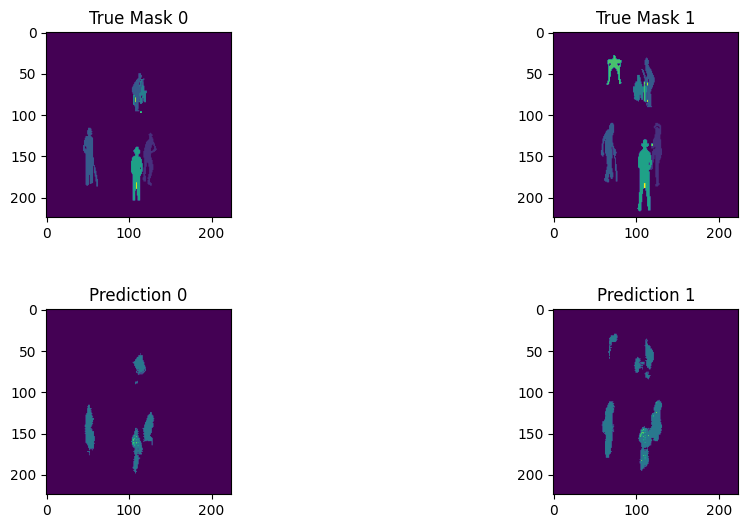

In [ ]:
predicted.size()
targets.size()
true_masks = targets
masks = predicted
print(true_masks.shape, masks.shape)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)

axs[0][0].imshow(true_masks[0])
axs[0][0].set_title("True Mask 0")

axs[0][1].imshow(true_masks[1])
axs[0][1].set_title("True Mask 1")


axs[1][0].imshow(masks[0])
axs[1][0].set_title("Prediction 0")

axs[1][1].imshow(masks[1])
axs[1][1].set_title("Prediction 1")


plt.show()
